# Homework 9

* **The first part is a simple review of ROC curves.**

* **The second part asks you to perform a K-nn regression on faces.**

**import libararies**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn import datasets
from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, log_loss, SCORERS

## ROC curves

* Find the best value of $K$ (optimizing the AUC on the iris test data):

In [68]:
iris = datasets.load_iris()
X = iris["data"][:,3:]
y = (iris["target"]==2).astype(np.int)

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

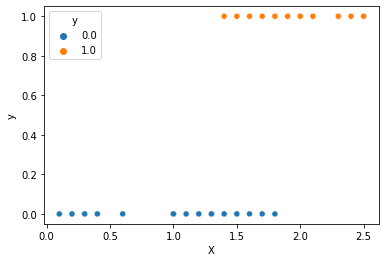

In [74]:
#Create df for scatterplot
df_train = pd.DataFrame(np.concatenate((X_train, y_train.reshape(-1,1)), axis=1), columns=["X","y"])

#Create plot with color coding
sns.scatterplot(x="X", y="y", hue="y", data=df_train);

In [163]:
knn = KNeighborsClassifier()

param_grid = {"n_neighbors":[1,3,5,9,15,21,31]}

grid_cv = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, scoring="roc_auc")

In [164]:
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 9, 15, 21, 31]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [165]:
grid_cv.best_params_

{'n_neighbors': 21}

In [166]:
grid_cv.cv_results_

{'mean_fit_time': array([0.00080166, 0.00104709, 0.00120983, 0.00148039, 0.00107822,
        0.00086703, 0.00064974]),
 'std_fit_time': array([1.28219606e-04, 1.78859921e-04, 4.22889361e-04, 1.03089311e-03,
        4.77560487e-04, 3.09217687e-04, 7.48487628e-05]),
 'mean_score_time': array([0.0037394 , 0.00535622, 0.0047998 , 0.00384951, 0.00432134,
        0.00331583, 0.0030365 ]),
 'std_score_time': array([0.00081844, 0.00132839, 0.00152266, 0.00082045, 0.00083692,
        0.00094284, 0.00063126]),
 'param_n_neighbors': masked_array(data=[1, 3, 5, 9, 15, 21, 31],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 3},
  {'n_neighbors': 5},
  {'n_neighbors': 9},
  {'n_neighbors': 15},
  {'n_neighbors': 21},
  {'n_neighbors': 31}],
 'split0_test_score': array([0.8 , 0.87, 0.88, 0.88, 0.95, 0.96, 0.95]),
 'split1_test_score': array([0.8 , 0.84, 0.84, 0.94, 0.95, 0.95, 

In [167]:
grid_cv.best_score_

0.982

In [168]:
y_pred = grid_cv.predict(X_test)

In [169]:
roc_auc_score(y_test, y_pred)

0.9782608695652174

## Face completion 

* The goal is to predict the lower half of a face given its upper half.

* The first column of images shows true faces. The second column illustrates how linear regression completes the lower half of those faces.

* Your task is to fill the third column with k nearest neighbors predictions.


In [2]:
# Load the faces datasets
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html
data = fetch_olivetti_faces()
targets = data.target

data = data.images.reshape((len(data.images), -1))
train = data[targets < 30]
test = data[targets >= 30]  

In [3]:
# Test on independent people
# Test on a subset of people
n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces, ))
test = test[face_ids, :]

n_pixels = data.shape[1]
# Upper half of the faces
X_train = train[:, :(n_pixels + 1) // 2]

# Lower half of the faces
y_train = train[:, n_pixels // 2:]
X_test = test[:, :(n_pixels + 1) // 2]
y_test = test[:, n_pixels // 2:]

ESTIMATORS = {
    "Linear regression": 1,
    "K-nn": 2,
}
# Fit estimators

y_test_predict = dict()

#Linear regression
estimator = LinearRegression()
estimator.fit(X_train, y_train)
y_test_predict["Linear regression"] = estimator.predict(X_test)

#kNN
knn_reg = KNeighborsRegressor()
param_grid = {"n_neighbors":[3,5,9,21,37,45,55,71]}
grid_knn_reg = GridSearchCV(knn_reg, param_grid, cv=10, scoring="neg_root_mean_squared_error",n_jobs=-1)
grid_knn_reg.fit(X_train, y_train)
y_test_predict["K-nn"] = grid_knn_reg.predict(X_test)

#The following is a placeholder that you need to change:
#y_test_predict["K-nn"] = y_test

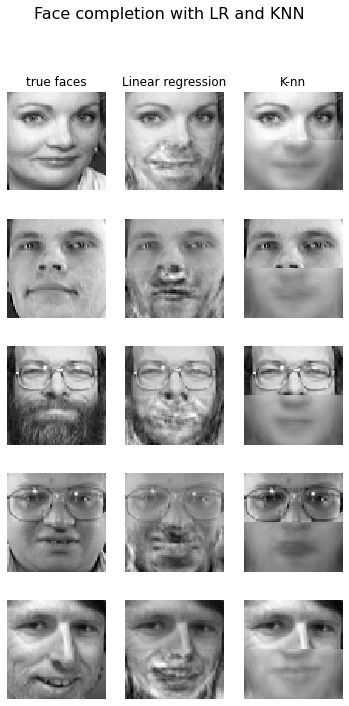

In [4]:
# Plot the completed faces
image_shape = (64, 64)

n_cols = 3
plt.figure(figsize=(2. * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with LR and KNN", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1, title="true faces")

    sub.axis("off")
    sub.imshow(true_face.reshape(image_shape),
               cmap=plt.cm.gray,
               interpolation="nearest")

    for j, est in enumerate(ESTIMATORS):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j,
                              title=est)

        sub.axis("off")
        sub.imshow(completed_face.reshape(image_shape),
                   cmap=plt.cm.gray,
                   interpolation="nearest")

## Advanced

* Change the code from above to predict the right half from the left half of the face.

In [14]:
# Load the faces datasets
#https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html
data = fetch_olivetti_faces()
targets = data.target

#irst row for pixels is columns, second is rows
#data = data.images.reshape((len(data.images), -1))

data = data.images
train = data[targets < 30]
test = data[targets >= 30]  

In [15]:
# Test on independent people
# Test on a subset of people
n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces, ))
test = test[face_ids, :]

n_pixels = data.shape[1]
# Left half of the faces
X_train = train[:, :,:n_pixels//2].reshape(train.shape[0], -1)

# Right half of the faces
y_train = train[:, :,n_pixels//2:].reshape(train.shape[0], -1)
X_test = test[:, :,:n_pixels//2].reshape(test.shape[0], -1)
y_test = test[:, :,n_pixels//2:].reshape(test.shape[0], -1)


In [16]:
ESTIMATORS = {
    "Linear regression": 1,
    "K-nn": 2,
}
# Fit estimators

y_test_predict = dict()

#Linear regression
estimator = LinearRegression()
estimator.fit(X_train, y_train)
y_test_predict["Linear regression"] = estimator.predict(X_test)

#kNN
knn_reg = KNeighborsRegressor()
param_grid = {"n_neighbors":[3,5,9,21,37,45,55,71]}
grid_knn_reg = GridSearchCV(knn_reg, param_grid, cv=10, scoring="neg_root_mean_squared_error",n_jobs=-1)
grid_knn_reg.fit(X_train, y_train)
y_test_predict["K-nn"] = grid_knn_reg.predict(X_test)

#The following is a placeholder that you need to change:
#y_test_predict["K-nn"] = y_test

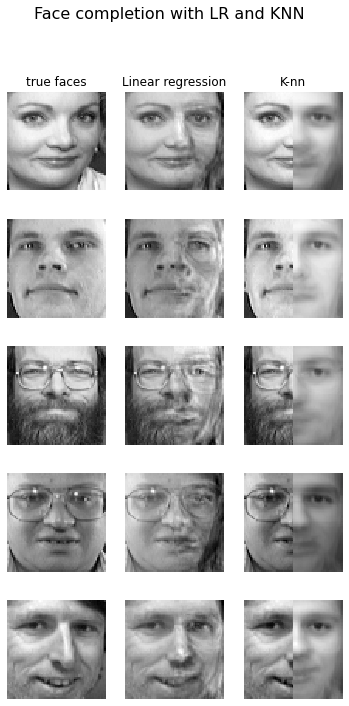

In [17]:
# Plot the completed faces
image_shape = (64, 64)

n_cols = 3
plt.figure(figsize=(2. * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with LR and KNN", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i].reshape(64,32), y_test[i].reshape(64,32)))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1, title="true faces")

    sub.axis("off")
    sub.imshow(true_face.reshape(image_shape),
               cmap=plt.cm.gray,
               interpolation="nearest")

    for j, est in enumerate(ESTIMATORS):
        completed_face = np.hstack((X_test[i].reshape(64,32), y_test_predict[est][i].reshape(64,32)))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j,
                              title=est)

        sub.axis("off")
        sub.imshow(completed_face.reshape(image_shape),
                   cmap=plt.cm.gray,
                   interpolation="nearest")